In [1]:
from trsm import TRSM, combos

In [2]:
filename = f'../signal/skimmed/NMSSM_XYH_YToHH_6b_MX_700_MY_400_testing_set_skimmed.root'
trsm = TRSM(filename=filename)

-- [INFO] -- /eos/user/s/srosenzw/miniconda3/envs/work/lib/python3.8/runpy.py -- Opening ROOT file ../signal/skimmed/NMSSM_XYH_YToHH_6b_MX_700_MY_400_testing_set_skimmed.root with columns
-- [INFO] -- /eos/user/s/srosenzw/miniconda3/envs/work/lib/python3.8/runpy.py -- Tree contains 52891 events.
----------------------------------------------------------------------------------------------------
                                            TABLE COLUMNS                                           
----------------------------------------------------------------------------------------------------
jet_pt                            jet_eta                           jet_phi                           
jet_m                             jet_btag                          jet_qgl                           
jet_idx                           jet_hadronFlav                    jet_partonFlav                    
HX_b1_recojet_m                   HX_b1_recojet_pt                  HX_b1_recojet_eta      

In [3]:
combos7 = combos(trsm, 7)

100%|██████████| 52891/52891 [00:24<00:00, 2169.33it/s]
Total events chosen: 8052


In [5]:
from keras.models import model_from_json
from pickle import load

In [8]:
tag = 'lr_0pt0001_beta1_0pt1_beta2_0pt5'

In [9]:
json_file = open(f'../models/classifier_6jet/{tag}/model/model_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(f'../models/classifier_6jet/{tag}/model/model_1.h5')
scaler = load(open(f'../models/classifier_6jet/{tag}/model/scaler_1.pkl', 'rb'))

In [10]:
test_features_7 = scaler.transform(combos7.combo_features)
scores_7 = loaded_model.predict(test_features_7)[:,0]
scores_7.shape

(56364,)

In [14]:
import awkward as ak
import numpy as np

In [26]:
combo_mask = combos7.combo_mask
HX_p4 = ak.to_numpy(combos7.HX_p4.m)[combo_mask]
H1_p4 = ak.to_numpy(combos7.H1_p4.m)[combo_mask]
H2_p4 = ak.to_numpy(combos7.H2_p4.m)[combo_mask]

correct_H = np.concatenate((HX_p4, H1_p4, H2_p4))
incorrect_H = ak.to_numpy(ak.flatten(combos7.incorrect_H_p4.m))

correct_H = correct_H.reshape(correct_H.shape[0],)
incorrect_H = incorrect_H.reshape(incorrect_H.shape[0],)

In [20]:
import matplotlib.pyplot as plt
from consistent_plots import hist, hist2d

In [18]:
def norm_hist(arr, bins=100):
    n, b = np.histogram(arr, bins=bins)
    x = (b[:-1] + b[1:]) / 2
    
    return n/n.max(), b, x

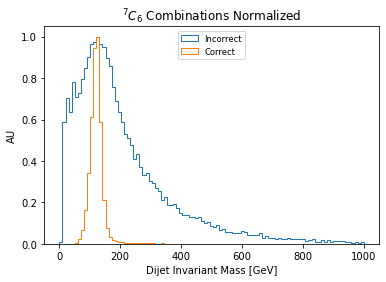

In [21]:
fig, ax = plt.subplots()

ax.set_title(r"$^7C_6$ Combinations Normalized")

n7_1, b7, x7 = norm_hist(incorrect_H, bins=np.linspace(0,1000,100))
n7_2, b7, x7 = norm_hist(correct_H, bins=np.linspace(0,1000,100))

hist(ax, x7, weights=n7_1, bins=b7, label='Incorrect')
hist(ax, x7, weights=n7_2, bins=b7, label='Correct')
ax.legend(fontsize='small', loc=9)

ax.set_xlabel(r'Dijet Invariant Mass [GeV]')
ax.set_ylabel('AU')

plt.show()

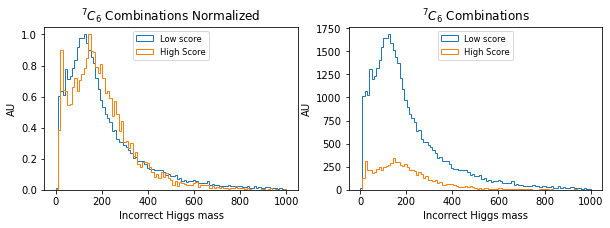

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

ax = axs[0]
ax.set_title(r"$^7C_6$ Combinations Normalized")

n7_1, b7, x7 = norm_hist(incorrect_H[scores_7[~combos7.sgnl_mask] <= 0.8], bins=np.linspace(0,1000,100))
n7_2, b7, x7 = norm_hist(incorrect_H[scores_7[~combos7.sgnl_mask] > 0.8], bins=np.linspace(0,1000,100))

hist(ax, x7, weights=n7_1, bins=b7, label='Low score')
hist(ax, x7, weights=n7_2, bins=b7, label='High Score')
ax.legend(fontsize='small', loc=9)

ax.set_xlabel('Incorrect Higgs mass')
ax.set_ylabel('AU')

ax = axs[1]
ax.set_title(r"$^7C_6$ Combinations")

n7_1, b7 = np.histogram(incorrect_H[scores_7[~combos7.sgnl_mask] <= 0.8], bins=np.linspace(0,1000,100))
n7_2, b7 = np.histogram(incorrect_H[scores_7[~combos7.sgnl_mask] > 0.8], bins=np.linspace(0,1000,100))

hist(ax, x7, weights=n7_1, bins=b7, label='Low score')
hist(ax, x7, weights=n7_2, bins=b7, label='High Score')
ax.legend(fontsize='small', loc=9)

ax.set_xlabel('Incorrect Higgs mass')
ax.set_ylabel('AU')

plt.show()

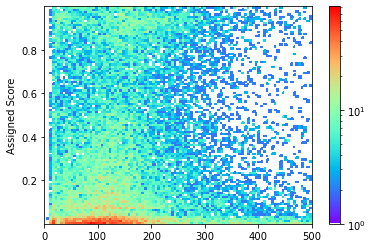

In [27]:
fig, ax = plt.subplots()

n, x, y, im = hist2d(ax, incorrect_H, scores_7[~combos7.sgnl_mask], xbins=np.linspace(0,500,100))
plt.colorbar(im, ax=ax)

ax.set_ylabel("Assigned Score")

plt.show()